<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/nlp/scikit_LDA_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# topics are indicated by an expert for each social network post
filename = '512_posts_24_topics.csv'

# the number of topics the Latent Dirichlet Allocation (LDA) model must extract from the set of documents
n_components = 24



In [39]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
!pip install -U pymorphy3
import pymorphy3
import requests
import csv
import gzip
import shutil

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.corpus import stopwords
stop_words = stopwords.words("russian")

#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/RussianStopWords.txt').text.split('\n')
#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/stopwords-ru.txt').text.split()
alphabet = set('–∞–±–≤–≥–¥–µ—ë–∂–∑–∏–π–∫–ª–º–Ω–æ–ø—Ä—Å—Ç—É—Ñ—Ö—Ü—á—à—â—ä—ã—å—ç—é—è')
alphabet_dash = alphabet | {'-'}# alphabet + dash

morph = pymorphy3.MorphAnalyzer(lang='ru')

from io import StringIO
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/topics/{filename}')
df = pd.read_csv(StringIO(response.text), delimiter=',', encoding='utf-8')

In [40]:
def get_text_window(words, index, window_size=3):
    """Returns a context window of words around the given index."""
    start = max(0, index - window_size)
    end = min(len(words), index + window_size + 1)
    return ' '.join(words[start:end])

def contains_non_dash(s):
    """Check if a string consists not only dash characters."""
    return s.count('-') < len(s)

def process_text(text):
    sentences = sent_tokenize(text)  # Split into sentences
    processed_sentences = []

    for sentence in sentences:
        check_hash = False
        processed_parts = []
        words = word_tokenize(sentence)

        for i, w in enumerate(words):
          if len(w) == 1:
            continue
          if w == '#':
            check_hash = True
            continue
          if check_hash:
            check_hash = False
            continue

          # skip name and surname
          # w_tag = morph.parse(w.strip())[0].tag
          #if 'Surn' in w_tag or 'Name' in w_tag or 'Patr' in w_tag:
          #  context = get_text_window(words, i)
          #  print(f"Filtered name/surname: {w} | Context: {context}")  # Debug output for context
          #  continue

          if set(w.lower()).issubset(alphabet_dash) and contains_non_dash(w):
            res = morph.parse(w.lower())[0].normal_form
            if res and (res not in stop_words):
                  processed_parts.append(res)
          else:
            # has 4+ Cyrillic characters then will parse too (e.g. –±–ª–∂.–§–∞–¥–¥–µ—è –æ.–ê–ª–µ–∫—Å–∏—è –≥.–ü–µ—Ç—Ä–æ–∑–∞–≤–æ–¥—Å–∫–µ)
            if sum(1 for char in w.lower() if char in alphabet) >= 4:
              if ('\\' not in w) and ('/' not in w): # skip words-hyperlinks
                #context = get_text_window(words, i)
                #print(f"Filtered not subset(alphabet): {w} | Context: {context}")
                res = morph.parse(w.lower())[0].normal_form
                if res not in stop_words:
                  processed_parts.append(res)

        if processed_parts:
            last_word = processed_parts[-1]
            if last_word[-1] not in ".!?":
                #processed_parts.append(".")  # Add period at the end of sentence
                processed_parts[-1] += "."    # Attach period directly to the last word

        processed_sentences.append(" ".join(processed_parts))

    return " ".join(processed_sentences).strip()

In [41]:
!pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')

for index, row in df.iterrows():
    text = row['text'].lower()
    df.loc[index, 'normalized'] = process_text(row['text'].lower())


In [42]:
from sklearn.model_selection import train_test_split
train_docs, test_docs = train_test_split(df, test_size=0.2, random_state=42, shuffle=True) # –ø–æ—Å—á–∏—Ç–∞—Ç—å —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π —Å–æ—Ç–Ω–µ

In [43]:
unique_topics = train_docs['topic'].unique()
len(unique_topics)

25

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create TF-IDF matrix
#vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)
# TODO: CountVectorizer –ª—É—á—à–µ?
vectorizer = TfidfVectorizer(
    max_df=0.8,        # –ò–≥–Ω–æ—Ä–∏—Ä–æ–≤–∞—Ç—å —Å–ª–∏—à–∫–æ–º —á–∞—Å—Ç—ã–µ —Å–ª–æ–≤–∞ (–≤ >80% –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤)
    min_df=2,          # –ò–≥–Ω–æ—Ä–∏—Ä–æ–≤–∞—Ç—å —Å–ª–æ–≤–∞, –≤—Å—Ç—Ä–µ—á–∞—é—â–∏–µ—Å—è —Ç–æ–ª—å–∫–æ –æ–¥–∏–Ω —Ä–∞–∑
    max_features=1000, # –£–º–µ—Ä–µ–Ω–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
#    stop_words=stop_words,  # —É–∂–µ —É–±—Ä–∞–ª–∏
)

# Transform text into TF-IDF matrix
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])
doc_test_matrix = vectorizer.transform(test_docs['normalized'])

# Get feature names
words = vectorizer.get_feature_names_out()

# Generate topic labels
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

# Fit LDA model
lda = LatentDirichletAllocation(
    n_components=n_components,
    n_jobs=-1,
    max_iter=77,
    learning_method='batch',
    evaluate_every=10,
    verbose=1,
    random_state=42
)
lda.fit(doc_train_matrix)


# Save and load the model
joblib.dump(lda, 'model.pkl')
lda = joblib.load('model.pkl')

# Compute topic-word probabilities
topics_count = lda.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)

# –ø–æ—á–µ–º—É –ø–µ—Ä–≤—ã–π —Å—Ç–æ–ª–±–µ—Ü - —ç—Ç–æ –Ω–∞–∑–≤–∞–Ω–∏—è –≥—Ä—É–ø–ø—ã –≤ –í–ö (domain)?
topics.head()

iteration: 1 of max_iter: 77
iteration: 2 of max_iter: 77
iteration: 3 of max_iter: 77
iteration: 4 of max_iter: 77
iteration: 5 of max_iter: 77
iteration: 6 of max_iter: 77
iteration: 7 of max_iter: 77
iteration: 8 of max_iter: 77
iteration: 9 of max_iter: 77
iteration: 10 of max_iter: 77, perplexity: 60244.2570
iteration: 11 of max_iter: 77
iteration: 12 of max_iter: 77
iteration: 13 of max_iter: 77
iteration: 14 of max_iter: 77
iteration: 15 of max_iter: 77
iteration: 16 of max_iter: 77
iteration: 17 of max_iter: 77
iteration: 18 of max_iter: 77
iteration: 19 of max_iter: 77
iteration: 20 of max_iter: 77, perplexity: 46816.0845
iteration: 21 of max_iter: 77
iteration: 22 of max_iter: 77
iteration: 23 of max_iter: 77
iteration: 24 of max_iter: 77
iteration: 25 of max_iter: 77
iteration: 26 of max_iter: 77
iteration: 27 of max_iter: 77
iteration: 28 of max_iter: 77
iteration: 29 of max_iter: 77
iteration: 30 of max_iter: 77, perplexity: 44044.3664
iteration: 31 of max_iter: 77
iterati

Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6  \
100              0.000529  0.000517  0.000413  0.000581  0.000210  0.000779   
100—Å–ª–æ–≤–æ–∫–∞—Ä–µ–ª–∏—è  0.000529  0.000517  0.000413  0.000581  0.023026  0.000779   
club147415188    0.000529  0.000517  0.000413  0.000581  0.000210  0.000779   
club791498       0.000529  0.000517  0.000413  0.000581  0.000210  0.000779   
c–∞–º—ã–π            0.000529  0.000517  0.000413  0.000581  0.010526  0.000779   

                  Topic 7   Topic 8   Topic 9  Topic 10  ...  Topic 15  \
100              0.000072  0.000188  0.000532  0.000731  ...  0.000576   
100—Å–ª–æ–≤–æ–∫–∞—Ä–µ–ª–∏—è  0.000072  0.000188  0.000532  0.000731  ...  0.000576   
club147415188    0.000072  0.004645  0.000532  0.000731  ...  0.000576   
club791498       0.000072  0.000188  0.000532  0.000731  ...  0.000576   
c–∞–º—ã–π            0.000072  0.000188  0.000532  0.000731  ...  0.000576   

                 Topic 16  Topic 17  Topic 18  Topic 19  Topic 20  Topic 21  \
100              0.000939  0.000134  0.000587  0.000715  0.010512  0.000698   
100—Å–ª–æ–≤–æ–∫–∞—Ä–µ–ª–∏—è  0.000939  0.000134  0.000587  0.000715  0.000513  0.000698   
club147415188    0.000939  0.000134  0.000587  0.000715  0.000513  0.000698   
club791498       0.000939  0.000134  0.000587  0.000715  0.000513  0.000698   
c–∞–º—ã–π            0.000939  0.000134  0.000587  0.000715  0.000513  0.000698   

                 Topic 22  Topic 23  Topic 24  
100              0.000891   0.00071  0.000237  
100—Å–ª–æ–≤–æ–∫–∞—Ä–µ–ª–∏—è  0.000891   0.00071  0.002548  
club147415188    0.000891   0.00071  0.000237  
club791498       0.000891   0.00071  0.000237  
c–∞–º—ã–π            0.000891   0.00071  0.000237  

[5 rows x 24 columns]

In [45]:
# Extract top words per topic
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

Topic 1                     Topic 2     Topic 3     Topic 4  \
0      –∑–∞–≤—Ç—Ä–∞  –æ–ª–æ–Ω–µ—Ü–∫–∏–π–Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–π–º—É–∑–µ–π  –∫–∞—Ä–µ–ª—å—Å–∫–∏–π     –≤–æ–¥–æ–ø–∞–¥   
1    –∫–∞–ª–µ–≤–∞–ª–∞                      –æ–ª–æ–Ω–µ—Ü   –ø–æ–≥–æ–≤–æ—Ä–∫–∞  –ø–æ—Å—Ç–∞–Ω–æ–≤–∫–∞   
2        –ø–µ—á—å                     –∫–∞–ª–∏—Ç–∫–∞    –º–æ–ª–æ–¥—ë–∂—å        –∫–ª—É–±   
3       –ø–µ—á–∫–∞                       –∑–µ–º–ª—è     —Å–∫–æ–ª—å–∫–æ  —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ   
4       –¥–∞—Ä—å—è                      –≥–æ—Ä–µ—Ç—å     —Å–±–æ—Ä–Ω–∏–∫       –∫–∞—Ä–µ–ª   
5    —Ö—É–¥–æ–∂–Ω–∏–∫                    –∫–∞–ª–µ–≤–∞–ª–∞        –º–æ—Ä–µ        —é–Ω—ã–π   
6    –∑–∞–ø–∏—Å–∞—Ç—å                      –º–æ–ª–æ–∫–æ        —Å–æ—é–∑       —É–ª–∏—Ü–∞   
7   –Ω–µ–±–æ–ª—å—à–æ–π                    —Ç–≤–µ—Ä—Å–∫–æ–π   –ø–æ—Å–ª–æ–≤–∏—Ü–∞    —Ç–≤–µ—Ä—Å–∫–æ–π   
8   –≤–∏–∫—Ç–æ—Ä–∏–Ω–∞                       –ø—É—Å—Ç—å       –∑–Ω–∞—Ç—å      –∞—Ä—Ç–∏—Å—Ç   
9       —Ñ–æ—Ä–º–∞                –æ—Ä–≥–∞–Ω–∏–∑–æ–≤–∞—Ç—å         —ç—Ö–æ       —Å—é–∂–µ—Ç   
10    –∫–∞–ª–∏—Ç–∫–∞                        —Å–Ω–µ–≥       —Å—ä–µ–∑–¥     —Ö–æ–∑—è–π–∫–∞   
11  –ø–µ—Ä–∏–æ–¥–∏–∫–∞                    —Ä–µ–¥–∞–∫—Ü–∏—è      –¥—Ä—É–∂–±–∞     —É—á–∞—Å—Ç–æ–∫   

            Topic 5         Topic 6     Topic 7          Topic 8  \
0            –ø—Ä–∏–º–µ—Ä            –∏—é–ª—å     –∫–∞—Ä–µ–ª–∏—è          –∫–æ–Ω–∫—É—Ä—Å   
1             —Å–ª–æ–≤–æ       —Ñ–µ—Å—Ç–∏–≤–∞–ª—å  —Ä–µ—Å–ø—É–±–ª–∏–∫–∞     –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–π   
2              —è–∑—ã–∫          –≥—Ä—É–ø–ø–∞         –≥–æ–¥      –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è   
3              —Å–≤–æ–π      –æ–±—Å—É–∂–¥–µ–Ω–∏–µ         —ç—Ç–æ         –∫—É–ª—å—Ç—É—Ä–∞   
4             —Å—Ç–µ–Ω–∞           –æ—Ç—Ä—è–¥        –≤–µ—Å—å         —Ä–∞–∑–≤–∏—Ç–∏–µ   
5            –Ω–µ–¥–µ–ª—è          –ø–æ–º–æ—á—å         –Ω–∞—à           –∑–∞—è–≤–∫–∞   
6   100—Å–ª–æ–≤–æ–∫–∞—Ä–µ–ª–∏—è  –ø—Ä–∏—Å–æ–µ–¥–∏–Ω—è—Ç—å—Å—è        –¥–µ–Ω—å     –º–∏–Ω–∏—Å—Ç–µ—Ä—Å—Ç–≤–æ   
7      –æ–ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å            –º–∞—Ç—å     –∫–æ—Ç–æ—Ä—ã–π     –æ–±—â–µ—Å—Ç–≤–µ–Ω–Ω—ã–π   
8             –∫–æ–Ω–µ—Ü        –¥–µ–ª–∏—Ç—å—Å—è       —Ä–∞–π–æ–Ω  –≥–æ—Å—É–¥–∞—Ä—Å—Ç–≤–µ–Ω–Ω—ã–π   
9           –ø–µ—Ä–µ–≤–æ–¥        –≤–Ω–∏–º–∞–Ω–∏–µ      —Ä–∞–±–æ—Ç–∞          –æ–±–ª–∞—Å—Ç—å   
10       –∫–∞—Ä–µ–ª—å—Å–∫–∏–π           –Ω–∞–π—Ç–∏       –Ω–æ–≤—ã–π       –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è   
11          –ø–æ–¥–∞—Ä–æ–∫          —Ä–µ–ø–æ—Å—Ç       –Ω–∞—Ä–æ–¥         –ø–æ–ª–∏—Ç–∏–∫–∞   

         Topic 9       Topic 10  ...    Topic 15   Topic 16     Topic 17  \
0          –∫–∞—Ä–µ–ª           –∑–∏–º–∞  ...     –∫–∞—Ä–µ–ª–æ–≤      –¥–æ—Å–∫–∞   –∫–∞—Ä–µ–ª—å—Å–∫–∏–π   
1          –æ—Ç–≤–µ—Ç           –∫–∏–∂–∏  ...     –Ω–∞—É—á–Ω—ã–π  –Ω–∞—É—á–∏—Ç—å—Å—è     –Ω–∞—Ä–æ–¥–Ω—ã–π   
2   —Å–æ—Ä–µ–≤–Ω–æ–≤–∞–Ω–∏–µ          —Å–æ–≤–µ—Ç  ...    —è–∑—ã–∫–æ–≤–æ–π   –ø—Ä–æ—Å–º–æ—Ç—Ä        –ø–µ—Å–Ω—è   
3         —Å—Ç–∞—Ä—ã–π         —Ä–µ–º–æ–Ω—Ç  ...    –∏–Ω—Å—Ç–∏—Ç—É—Ç      –±–ª—é–¥–æ     –∫—É–ª—å—Ç—É—Ä–∞   
4        —Ö–æ—Ä–æ–≤–æ–π         –¥–æ—Ä–æ–≥–∞  ...   —Å–æ—Ç—Ä—É–¥–Ω–∏–∫   –≥–æ—Ç–æ–≤–∏—Ç—å          —Ö–æ—Ä   
5           —Ä–µ—á—å       –≤–ª–∞–¥–∏–º–∏—Ä  ...    –∏–≤–∞–Ω–æ–≤–∏—á    –∫–∞–ª–∏—Ç–∫–∞    –∫–æ–ª–ª–µ–∫—Ç–∏–≤   
6           –ø—Ä–∏–∑         —Ç—Ä–∞—Å—Å–∞  ...        –¥–µ–Ω—å      –∫—É—Ö–Ω—è  –º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏–µ   
7         –∞–≤–≥—É—Å—Ç         –æ–±—ä–µ–∫—Ç  ...  –ª–∏—Ç–µ—Ä–∞—Ç—É—Ä–∞     –¥–µ–ª–∞—Ç—å         —Ä—É–Ω–æ   
8        –∞–∫—Ç–∏–≤–Ω–æ     —É–∫—Ä–µ–ø–ª–µ–Ω–∏–µ  ...    –∫–∞–ª–µ–≤–∞–ª–∞   –ø—Ä–∏—è—Ç–Ω—ã–π      –∫–∞—Ä–µ–ª–∏—è   
9          –ø–µ–Ω–∏–µ      –ø—Ä–æ—Ö–æ–¥–∏—Ç—å  ...         —Ä–∞–Ω      –≤–∏–¥–µ–æ  –º—É–∑—ã–∫–∞–ª—å–Ω—ã–π   
10       —Å–æ–±—ã—Ç–∏–µ         —Ä–∞–Ω–Ω–∏–π  ...    –æ–Ω–µ–∂—Å–∫–∏–π     –ø–æ–º–æ—â—å     –∫–∞–ª–µ–≤–∞–ª–∞   
11        –ø—Ä–∏–π—Ç–∏  –ø—Ä–µ–¥—Å—Ç–∞–≤–∏—Ç–µ–ª—å  ...        —Ñ–∏–Ω–Ω     –∫–∞–∂–¥—ã–π         –≤–æ–¥–∞   

             Topic 18    Topic 19        Topic 20    Topic 21     Topic 22  \
0               —Å—É—Ç–∫–∏  –ø–∏—Ç–∫—è—Ä–∞–Ω—Ç–∞            –Ω–æ

In [46]:
# Predict topic distribution for training data
train_preds = lda.transform(doc_train_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)

# Prepare topic assignment per document
df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)

<ipython-input-46-23a62e146ad4>:6: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)


Text(0.5, 1.0, 'Training: Topic Distribution')

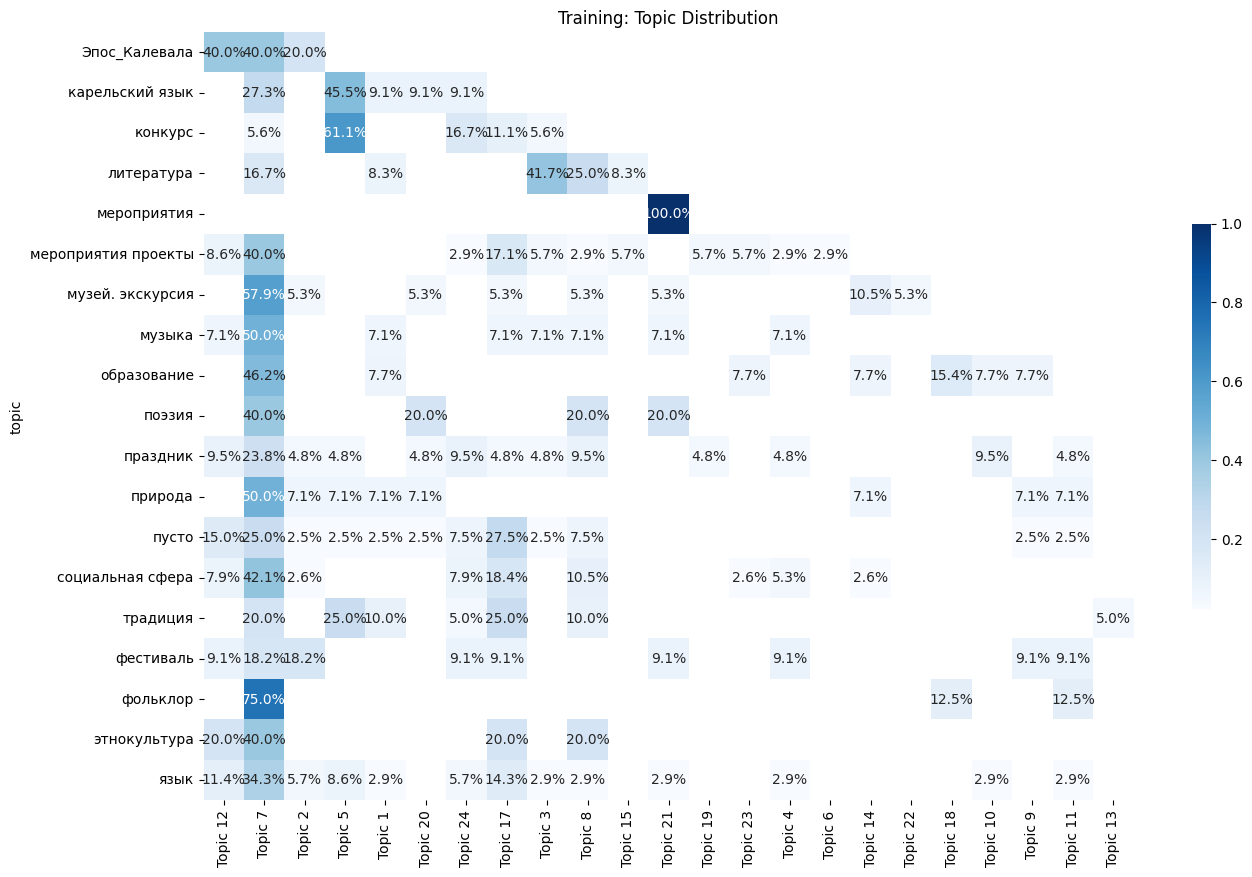

In [47]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#df = train_eval.groupby(level='topic').idxmax(
#    axis=1).reset_index(-1, drop=True)

# Plot heatmap of topic distribution
plt.figure(figsize=(15, 10))
sns.heatmap(
    df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1),
    annot=True,
    fmt='.1%',
    cmap='Blues',
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Training: Topic Distribution')
#plt.title('–û–±—É—á–µ–Ω–∏–µ: –¢–µ–º–∞—Ç–∏–∫–∏')

#plt.figure(figsize=(15, 40))
#sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
#            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
#plt.title('–û–±—É—á–µ–Ω–∏–µ: –¢–µ–º–∞—Ç–∏–∫–∏')


In [48]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval

Topic 1   Topic 2   Topic 3   Topic 4   Topic 5  \
topic                                                                      
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.011158  0.011158  0.011158  0.011158  0.178431   
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.005852  0.090600  0.005852  0.005852  0.005852   
–ø—É—Å—Ç–æ                   0.006916  0.006916  0.006916  0.006916  0.006916   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ             0.006400  0.006400  0.006400  0.006400  0.006400   
–≤–µ–ø—Å—ã                   0.010229  0.010229  0.010229  0.010229  0.010229   
...                          ...       ...       ...       ...       ...   
—Ç—Ä–∞–¥–∏—Ü–∏—è                0.007330  0.007330  0.007330  0.007330  0.007330   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ             0.005943  0.005943  0.005943  0.005943  0.005943   
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.012194  0.012194  0.012194  0.012194  0.012194   
–¥–µ–Ω—å —Ä–æ–∂–¥–µ–Ω–∏—è –∏ —é–±–∏–ª–µ–π  0.004481  0.004481  0.037194  0.004481  0.004481   
—Ç—Ä–∞–¥–∏—Ü–∏—è                0.008120  0.008120  0.468541  0.008120  0.008120   

                         Topic 6   Topic 7   Topic 8   Topic 9  Topic 10  ...  \
topic                                                                     ...   
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.267819  0.011158  0.011158  0.011158  0.011158  ...   
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.005852  0.350050  0.375595  0.005852  0.005852  ...   
–ø—É—Å—Ç–æ                   0.006916  0.251630  0.006916  0.006916  0.006916  ...   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ             0.006400  0.362680  0.093430  0.006400  0.006400  ...   
–≤–µ–ø—Å—ã                   0.010229  0.764744  0.010229  0.010229  0.010229  ...   
...                          ...       ...       ...       ...       ...  ...   
—Ç—Ä–∞–¥–∏—Ü–∏—è                0.007330  0.223811  0.007330  0.007330  0.007330  ...   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ             0.005943  0.281702  0.107679  0.005943  0.005943  ...   
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.012194  0.012194  0.012194  0.012194  0.012194  ...   
–¥–µ–Ω—å —Ä–æ–∂–¥–µ–Ω–∏—è –∏ —é–±–∏–ª–µ–π  0.004481  0.401857  0.205660  0.015919  0.004481  ...   
—Ç—Ä–∞–¥–∏—Ü–∏—è                0.008120  0.352829  0.008120  0.008120  0.008120  ...   

                        Topic 15  Topic 16  Topic 17  Topic 18  Topic 19  \
topic                                                                      
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.011158  0.011158  0.319435  0.011158  0.011158   
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.005852  0.005852  0.005852  0.005852  0.005852   
–ø—É—Å—Ç–æ                   0.006916  0.006916  0.204182  0.006916  0.006916   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ             0.006400  0.006400  0.306588  0.006400  0.006400   
–≤–µ–ø—Å—ã                   0.010229  0.010229  0.010229  0.010229  0.010229   
...                          ...       ...       ...       ...       ...   
—Ç—Ä–∞–¥–∏—Ü–∏—è                0.007330  0.007330  0.007330  0.007330  0.007330   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ             0.078034  0.005943  0.169269  0.005943  0.046352   
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.012194  0.012194  0.719527  0.012194  0.012194   
–¥–µ–Ω—å —Ä–æ–∂–¥–µ–Ω–∏—è –∏ —é–±–∏–ª–µ–π  0.004481  0.004481  0.161434  0.004481  0.004481   
—Ç—Ä–∞–¥–∏—Ü–∏—è                0.008120  0.008120  0.008120  0.008120  0.008120   

                        Topic 20  Topic 21  Topic 22  Topic 23  Topic 24  
topic                                                                     
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.011158  0.011158  0.011158  0.011158  0.011158  
–º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏—è –ø—Ä–æ–µ–∫—Ç—ã     0.066724  0.005852  0.005852  0.005852  0.005852  
–ø—É—Å—Ç–æ                   0.398958  0.006916  0.006916  0.006916  0.006916  
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ             0.086882  0.006400  0.006400  0.006400  0.006400  
–≤–µ–ø—Å—ã                   0.010229  0.010229  0.010229  0.010229  0.010229  
...                          ...       ...      

In [49]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.topic)
test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.topic)

<ipython-input-49-827e74a28c9f>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(


**–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –≤ –≤–∏–¥–µ —Ç–µ–ø–ª–æ–≤–æ–π –∫–∞—Ä—Ç—ã (heatmap) –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–µ–º –≤ –Ω–∞–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö: —Ç–µ—Å—Ç–æ–≤—ã–π (test_eval)**

<ipython-input-50-9b315acb5e67>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = test_eval.groupby(level='topic').idxmax(


Text(0.5, 1.0, '–î–∞–Ω–Ω—ã–µ –æ–±—É—á–µ–Ω–∏—è: –¢–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –∑–∞–¥–∞–Ω–∏—è')

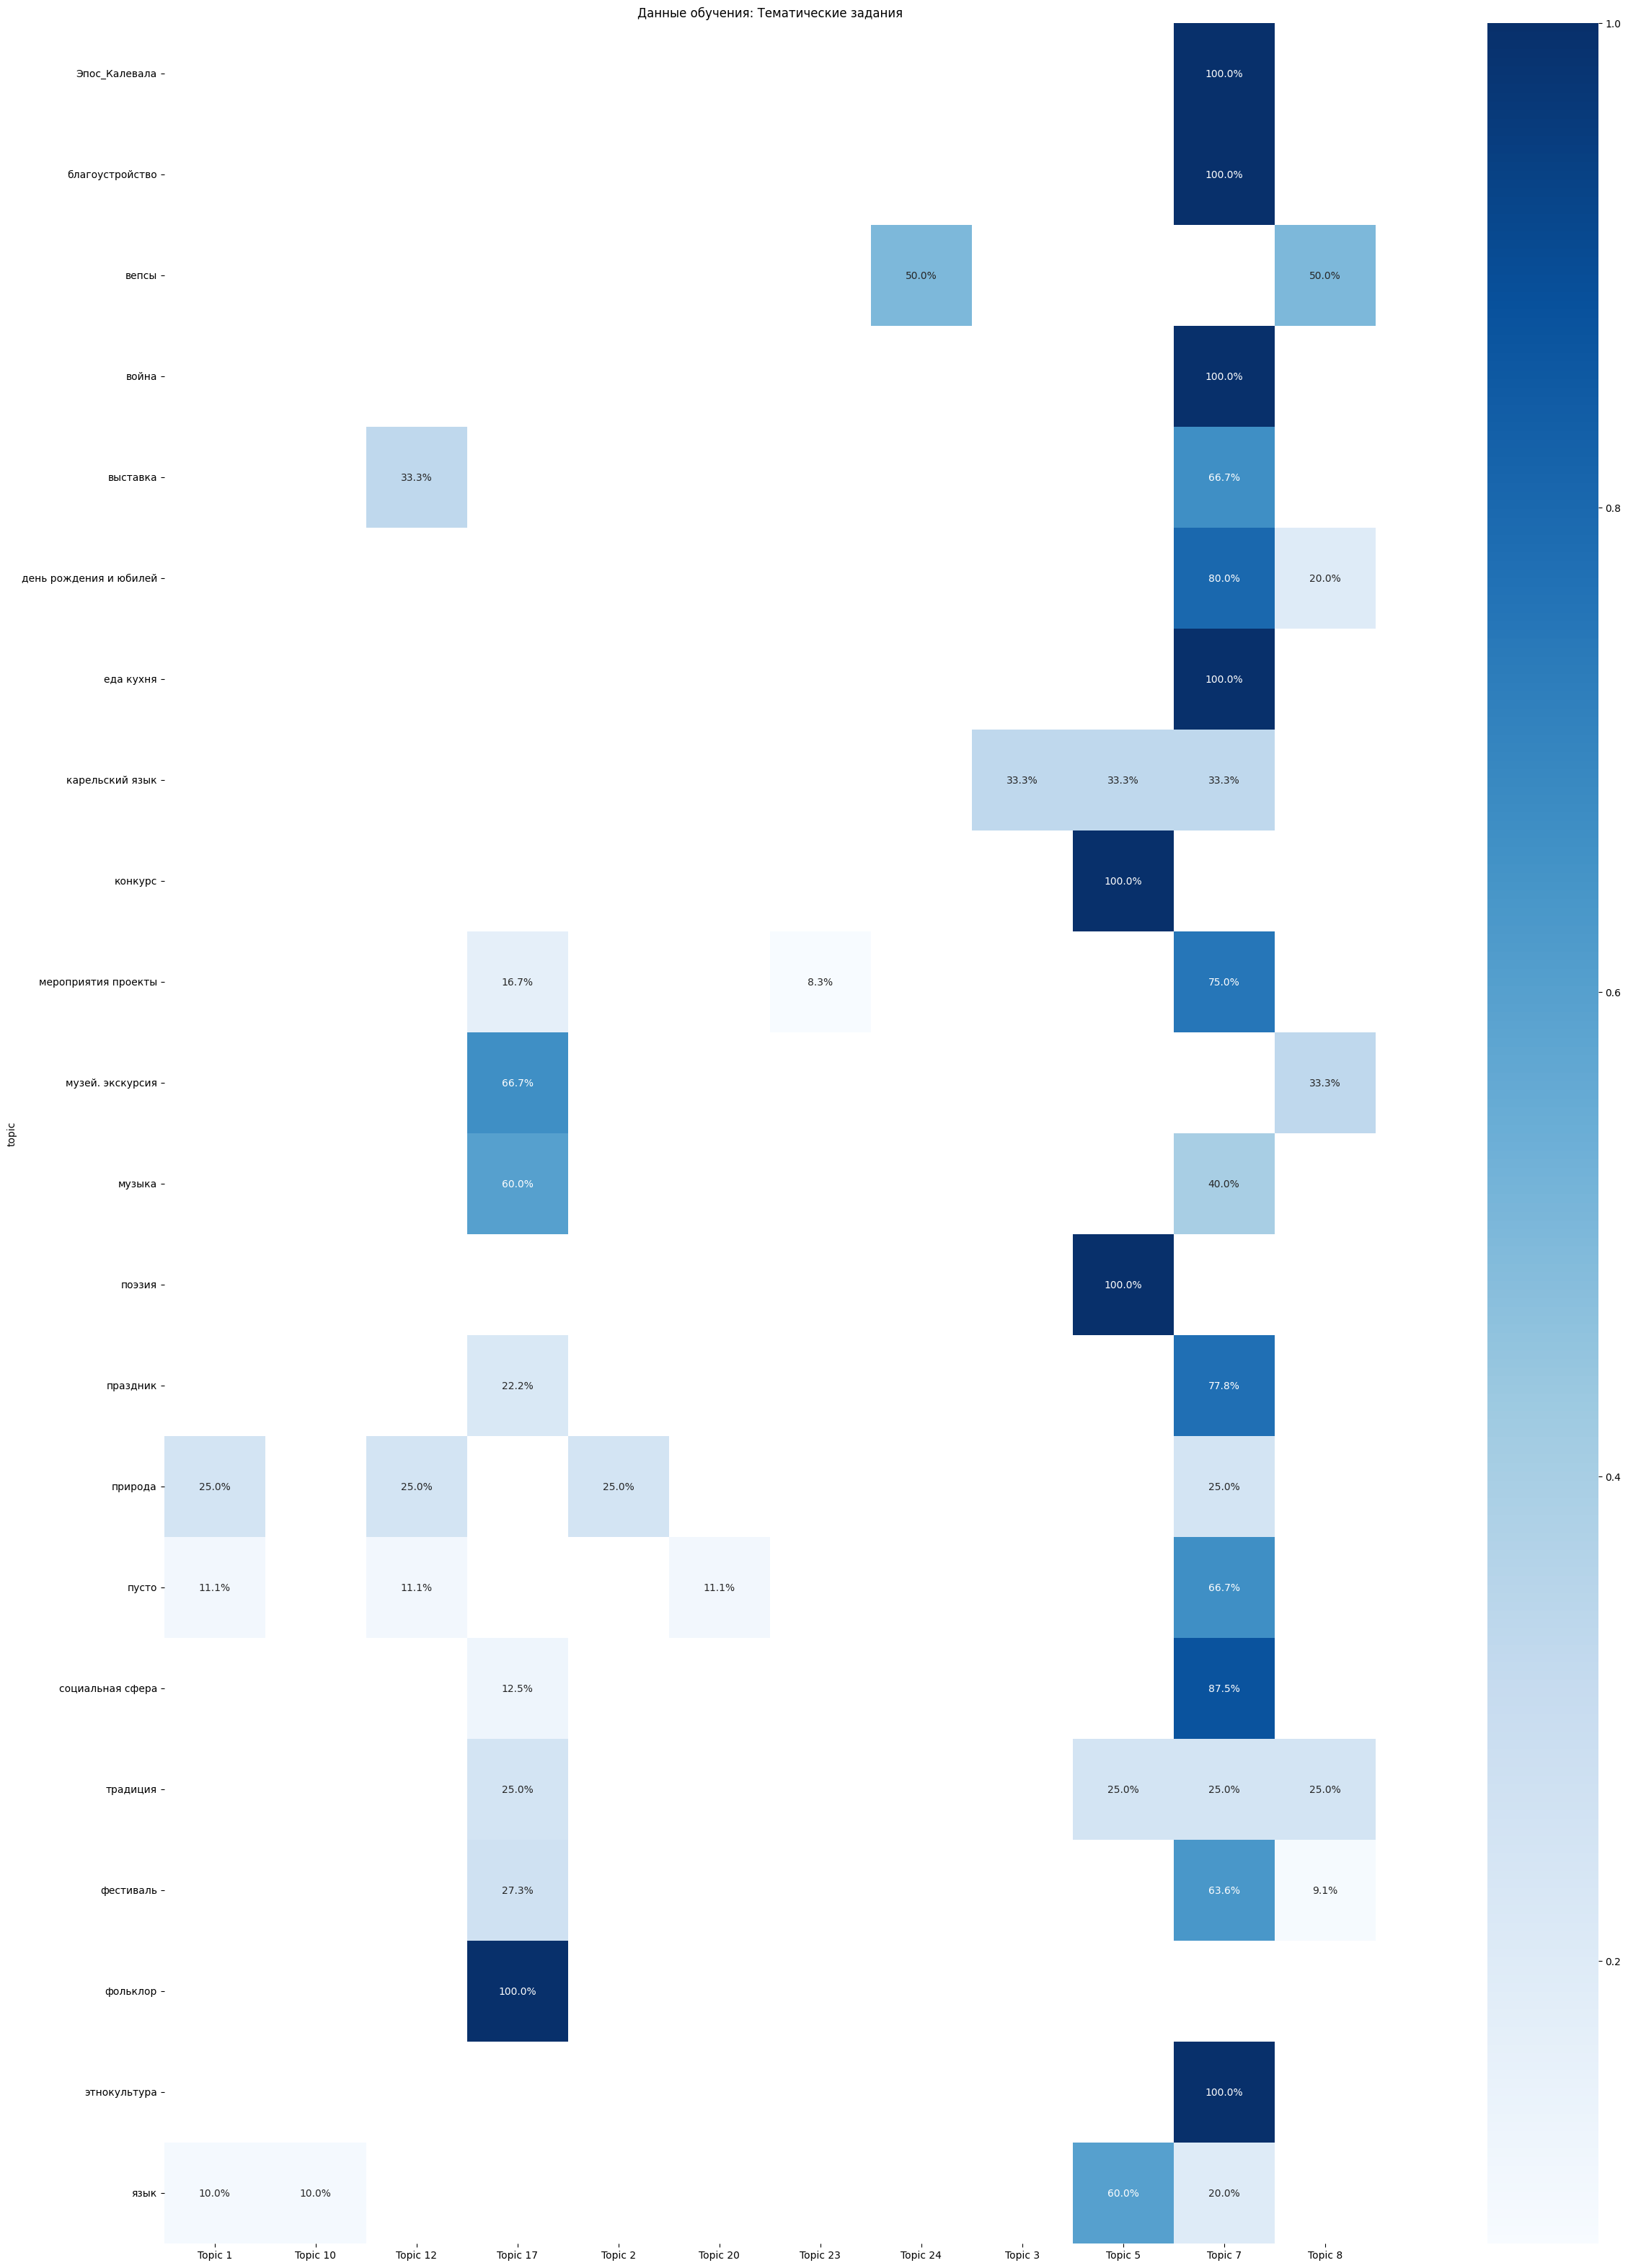

In [50]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(40, 40))
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('–î–∞–Ω–Ω—ã–µ –æ–±—É—á–µ–Ω–∏—è: –¢–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –∑–∞–¥–∞–Ω–∏—è')

In [51]:
test_assignments = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['text'] = test_docs.text.values
test_assignments.head(5)

<ipython-input-51-c37182911221>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = test_eval.groupby(level='topic').idxmax(


topic predicted  \
0    –≠–ø–æ—Å_–ö–∞–ª–µ–≤–∞–ª–∞   Topic 7   
1  –±–ª–∞–≥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ   Topic 7   
2  –±–ª–∞–≥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ   Topic 7   
3  –±–ª–∞–≥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ   Topic 7   
4  –±–ª–∞–≥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ   Topic 7   

                                                text  
0  –ë–µ—Ä–∏ –¥—Ä—É–∑–µ–π - —Å–º–æ—Ç—Ä–∏ –º—É–∑–µ–π!  –°–µ–≥–æ–¥–Ω—è –ø—Ä–∏–≥–ª–∞—à–∞–µ...  
1  Ô∏èüé•–ü—Ä–µ–¥–ª–∞–≥–∞–µ–º –≤–∞–º –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –∏–Ω—Ç–µ—Ä–µ—Å–Ω—ã–π —Ä–æ–ª–∏–∫ —Å...  
2  üí• –°–µ–≥–æ–¥–Ω—è —Ä—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å –ö–∞—Ä–µ–ª—å—Å–∫–æ–π —Ä–µ—Å–ø—É–±–ª–∏–∫–∞–Ω—Å...  
3  "–û–°–ï–ù–¨ –í—ä –ì–û–†–û–î—£ –û."üçÅüçÇ –ú–ê–°–¢–ï–†-–ö–õ–ê–°–° –ü–û –°–ö–ê–ù–î–ò–ù...  
4  –ö–∞–∫–æ–µ —Ä–∞—Å—Ç–µ–Ω–∏–µ –≤–µ–ø—Å—ã –Ω–∞–∑—ã–≤–∞—é—Ç "GADAN LUZIK" –±—É...

In [52]:
test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)
                   .reset_index(-1, drop=True)
                   .to_frame('predicted')
                   .reset_index())

test_assignments['text'] = test_docs.text.values

war_assignments = test_assignments[test_assignments['topic'] == '–≤–æ–π–Ω–∞']
war_assignments
war_assignments.to_csv("war.csv")

<ipython-input-52-2aea02cd00df>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)


In [53]:
test_assignments.to_csv("res.csv")